## simple debug setup

In [2]:
import os, osr, glob
import xarray as xr
import rioxarray
from rioxarray.merge import merge_datasets, merge_arrays
import numpy as np
import geopandas as gpd
#
from geocube.api import core
#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
#
import seaborn as sns
#
from equi7grid.equi7grid import Equi7Grid
#%matplotlib widget
#%matplotlib inline

Set the tile, orbit, and polarisation to read:

In [3]:
#myTile = 'E066N060T3' # Rondonia
#myOrbit = 'D156' # Rondonia
#
myTile = 'E078N066T3' # Para
myOrbit = 'D039' # Para
#
myPol = 'VH'

In [4]:
# set the folter wih the output files:
data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  myTile + '_smallChanks'

In [5]:
# Equi7 SA wkt:
PROJ = 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",7257179.23559],PARAMETER["false_northing",5592024.44605],PARAMETER["central_meridian",-60.5],PARAMETER["latitude_of_origin",-14.0],UNIT["Meter",1.0]]'

In [6]:
# read multiple ckunks:
ChunkDatasetList = []
# set the rwos and columns:
#myCols, myRows = np.meshgrid(np.arange(34, 38), np.arange(42, 46)) # Rondonia
myCols, myRows = np.meshgrid(np.arange(20, 24), np.arange(36, 40)) # Para
# read each one
for myRow, myCol in zip(myRows.flatten(), myCols.flatten()):
    # set filename:
    fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + myOrbit + '_'+ myPol + '.nc'
    aux_ds = rioxarray.open_rasterio(os.path.join(data_folder, fileName))
    # set crs:
    aux_ds.rio.write_crs(PROJ, inplace=True)
    ChunkDatasetList.append(aux_ds)      

In [7]:
# mearge chanks spatialy:
my_out = merge_datasets(ChunkDatasetList)   

In [60]:
my_out

<xarray.Dataset>
Dimensions:           (band: 1, y: 1000, x: 1000)
Coordinates:
  * band              (band) int64 1
  * x                 (x) float64 7.9e+06 7.9e+06 7.9e+06 ... 7.92e+06 7.92e+06
  * y                 (y) float64 6.72e+06 6.72e+06 6.72e+06 ... 6.7e+06 6.7e+06
    spatial_ref       int64 0
Data variables: (12/73)
    exception_label   (band, y, x) float64 3.0 3.0 3.0 3.0 ... 2.0 0.0 0.0 0.0
    max_mag           (band, y, x) float64 nan nan nan nan ... 1.347 1.8 1.894
    max_mag_date      (band, y, x) float64 nan nan nan ... 2.02e+03 2.02e+03
    t_pre             (band, y, x) float64 nan nan nan nan ... -6.0 -37.0 -24.0
    t_post            (band, y, x) float64 nan nan nan nan ... 12.0 29.0 24.0
    t_total           (band, y, x) float64 nan nan nan nan ... 24.0 390.0 54.0
    ...                ...
    MAD_2017          (band, y, x) float64 0.7 1.0 0.9 0.7 ... 0.8 0.8 0.7 0.7
    MAD_2018          (band, y, x) float64 0.6 0.9 0.9 0.7 ... 0.8 0.9 0.8 0.8
    MAD_2019          (band, y, x) float64 0.9 1.0 0.5 0.7 ... 0.9 0.7 0.7 0.9
    MAD_2020          (band, y, x) float64 1.0 0.85 0.8 0.9 ... 1.05 0.65 0.85
    seg_id            (band, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    seg_size          (band, y, x) float64 nan nan nan nan ... 36.0 108.0 84.0

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Read forest age and LULC data:

In [8]:
# fileName2 = r'myforAgeLCLU_2017_2020_equi7_E066N060T3_20m.tif' # Rondonia
fileName2 = r'myforAgeLCLU_2017_2020_equi7_E078N066T3_20m.tif' # Para
forAgeLULC = rioxarray.open_rasterio(fileName2, band_as_variable=True)
# convert to dataset:
forAgeLULC_ds = forAgeLULC.to_dataset('band').rename({1: 'forAge2017', 2: 'lulc2018', 3: 'lulc2019', 4: 'forAge2020', 5: 'ECO_ID'})

Correct coordinates (temporary soluton!!!)

In [9]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(x=forAgeLULC_ds.x - 10 )

In [10]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(y=forAgeLULC_ds.y + 10 )

Join datasets and clip forAgeLCLU to my_out coordinates:

In [11]:
all_ds = xr.merge([my_out.isel(band=0, drop=True), forAgeLULC_ds], join='inner') 

## Add annual statistics

In [12]:
# Add the combined annual statistics:
all_ds['qDiff_2017'] = all_ds['q90_2017'] - all_ds['q10_2017']
all_ds['dRange_2017'] = all_ds['max_2017'] - all_ds['min_2017']
all_ds['iqRange_2017'] = all_ds['q75_2017'] - all_ds['q25_2017']

In [13]:
# set the relevant statistics:
myStatnames = ['mean_2017', 'median_2017', 'std_2017', 'MAD_2017', 'dRange_2017', 'qDiff_2017', 'iqRange_2017', 'forAge2017']
# mearge the arrays into new dataset:
my_ds = all_ds[myStatnames]

In [14]:
# select secondary and OLD forest and convert to pandas data frame
my_df = my_ds.where((my_ds['forAge2017'] > 0) | (my_ds['forAge2017'] == 50)).to_dataframe()
# drop unneccery data:
my_df.drop(columns='spatial_ref', inplace=True)
my_df.dropna(subset=['forAge2017'], inplace=True)

## Split Old forest in negative age classes:

In [32]:
# get secondary forest pixels
my_df_secFor = my_ds.where((my_ds['forAge2017'] > 0) & (my_ds['forAge2017'] < 50)).to_dataframe()
my_df_secFor.drop(columns='spatial_ref', inplace=True)
my_df_secFor.dropna(subset=['forAge2017'], inplace=True)
# get old forest pixels:
my_df_oldFor = my_ds.where(my_ds['forAge2017'] == 50).to_dataframe()
my_df_oldFor.drop(columns='spatial_ref', inplace=True)
my_df_oldFor.dropna(subset=['forAge2017'], inplace=True)

In [33]:
# get the number of secFor pixels per age
secFor_count = my_df_secFor.groupby(by='forAge2017').count()
# get the average num of secFor pixels in 5 largest ages:
myPixNum = np.int32(np.floor(np.mean(secFor_count.mean_2017.nlargest(5).values)))

In [34]:
# add several old forest pixel groups as negatavive forest age into secFor dataframe:
for oldForAge in np.arange(-60, 1):
    aux1 = my_df_oldFor.sample(myPixNum)
    aux1['forAge2017'] = oldForAge
    # append secFor pixels:
    my_df_secFor = my_df_secFor.append(aux1)
    
# reset the index:
my_df_secFor.reset_index(inplace=True)

## Get the grouped statistict:

In [35]:
# group by year:
df_med = my_df_secFor.groupby(by='forAge2017').mean()

In [36]:
RefMed = my_df_oldFor.mean()

## Plotting

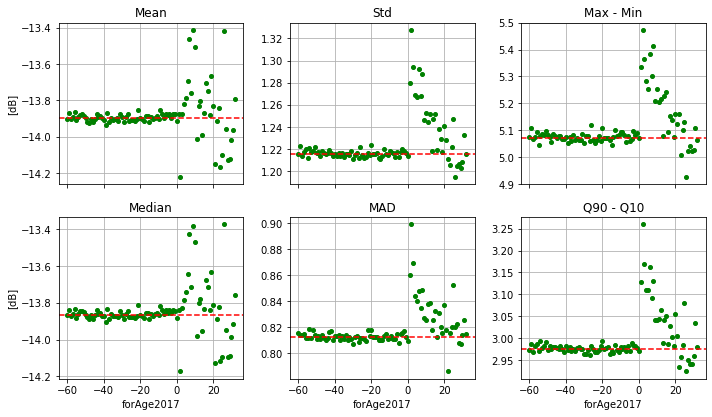

In [20]:
#%matplotlib widget
#%matplotlib inline
#
fig, axs = plt.subplots(2, 3, figsize=(10, 5.9), sharex=True)
# add plots
df_med.mean_2017.plot(style='o', grid=True, ax=axs[0, 0], title='Mean', **{'markersize': 4, 'color':'green'})
axs[0, 0].axhline(y=RefMed.mean_2017, color='r', linestyle='--')
#
df_med.std_2017.plot(style='o', grid=True, ax=axs[0, 1], title='Std', **{'markersize': 4, 'color':'green'})
axs[0, 1].axhline(y=RefMed.std_2017, color='r', linestyle='--')
#
df_med.dRange_2017.plot(style='o', grid=True, ax=axs[0, 2], title='Max - Min', **{'markersize': 4, 'color':'green'})
axs[0, 2].axhline(y=RefMed.dRange_2017, color='r', linestyle='--')
#
df_med.median_2017.plot(style='o', grid=True, ax=axs[1, 0], title='Median', **{'markersize': 4, 'color':'green'})
axs[1, 0].axhline(y=RefMed.median_2017, color='r', linestyle='--')
#
df_med.MAD_2017.plot(style='o', grid=True, ax=axs[1, 1], title='MAD', **{'markersize': 4, 'color':'green'})
axs[1, 1].axhline(y=RefMed.MAD_2017, color='r', linestyle='--')
#
df_med.qDiff_2017.plot(style='o', grid=True, ax=axs[1, 2], title='Q90 - Q10', **{'markersize': 4, 'color':'green'})
axs[1, 2].axhline(y=RefMed.qDiff_2017, color='r', linestyle='--')
#
axs[0, 0].set_ylabel('[dB]')
axs[0, 1].set_ylabel('')
axs[0, 2].set_ylabel('')
#
axs[1, 0].set_ylabel('[dB]')
axs[1, 1].set_ylabel('')
axs[1, 2].set_ylabel('')
#
fig.tight_layout()


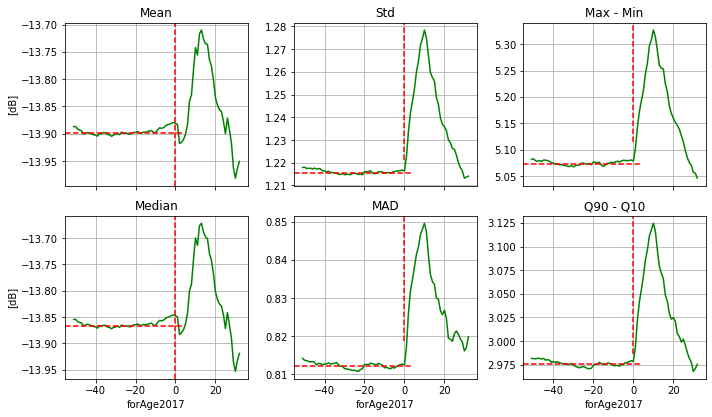

In [21]:
#matplotlib widget
#%matplotlib inline
#
fig, axs = plt.subplots(2, 3, figsize=(10, 5.9), sharex=True)
# add plots
df_med.mean_2017.rolling(10).mean().plot(grid=True, ax=axs[0, 0], title='Mean', **{'markersize': 4, 'color':'green'})
axs[0, 0].axhline(y=RefMed.mean_2017, xmax=0.65, color='r', linestyle='--')
axs[0, 0].axvline(x=0, color='r', linestyle='--')
#
df_med.std_2017.rolling(10).mean().plot(grid=True, ax=axs[0, 1], title='Std', **{'markersize': 4, 'color':'green'})
axs[0, 1].axhline(y=RefMed.std_2017, xmax=0.65, color='r', linestyle='--')
my_ymin = (RefMed.std_2017- df_med.std_2017.min())/(df_med.std_2017.max() - df_med.std_2017.min())
axs[0, 1].axvline(x=0, ymin=my_ymin, color='r', linestyle='--')
#
df_med.dRange_2017.rolling(10).mean().plot(grid=True, ax=axs[0, 2], title='Max - Min', **{'markersize': 4, 'color':'green'})
axs[0, 2].axhline(y=RefMed.dRange_2017, xmax=0.65, color='r', linestyle='--')
my_ymin = (RefMed.dRange_2017- df_med.dRange_2017.min())/(df_med.dRange_2017.max() - df_med.dRange_2017.min())
axs[0, 2].axvline(x=0, ymin=my_ymin, color='r', linestyle='--')
#
df_med.median_2017.rolling(10).mean().plot(grid=True, ax=axs[1, 0], title='Median', **{'markersize': 4, 'color':'green'})
axs[1, 0].axhline(y=RefMed.median_2017, xmax=0.65, color='r', linestyle='--')
axs[1, 0].axvline(x=0, color='r', linestyle='--')
#
df_med.MAD_2017.rolling(10).mean().plot(grid=True, ax=axs[1, 1], title='MAD', **{'markersize': 4, 'color':'green'})
axs[1, 1].axhline(y=RefMed.MAD_2017, xmax=0.65, color='r', linestyle='--')
my_ymin = (RefMed.MAD_2017- df_med.MAD_2017.min())/(df_med.MAD_2017.max() - df_med.MAD_2017.min())
axs[1, 1].axvline(x=0, ymin=my_ymin, color='r', linestyle='--')
#
df_med.qDiff_2017.rolling(10).mean().plot(grid=True, ax=axs[1, 2], title='Q90 - Q10', **{'markersize': 4, 'color':'green'})
axs[1, 2].axhline(y=RefMed.qDiff_2017, xmax=0.65, color='r', linestyle='--')
my_ymin = (RefMed.qDiff_2017- df_med.qDiff_2017.min())/(df_med.qDiff_2017.max() - df_med.qDiff_2017.min())
axs[1, 2].axvline(x=0, ymin=my_ymin, color='r', linestyle='--')
#
axs[0, 0].set_ylabel('[dB]')
axs[0, 1].set_ylabel('')
axs[0, 2].set_ylabel('')
#
axs[1, 0].set_ylabel('[dB]')
axs[1, 1].set_ylabel('')
axs[1, 2].set_ylabel('')
#
fig.tight_layout()


## Fit a model :

In [22]:
# select secundary forest only:
df_4fit = my_df_secFor[my_df_secFor.forAge2017>0]

In [23]:
# group by year:
df_4fit_grouped = df_4fit.groupby(by='forAge2017').mean().reset_index()

In [24]:
# prepare data for the MULTIVARIATE fit
X = df_4fit_grouped.drop(['forAge2017', 'x', 'y'], axis = 1)
#X = df_4fit_grouped.reset_index()[['std_2017']] # simple regression
y = df_4fit_grouped.reset_index()[['forAge2017']]

In [25]:
lm = LinearRegression()
model = lm.fit(X,y)

In [26]:
model.score(X,y)

0.8376310219988592

In [27]:
model.intercept_

array([218.24417591])

In [28]:
MSE = mean_squared_error(y,model.predict(X))
RMSE = np.sqrt(MSE)
RMSE

3.7204778422397915

# Feature space conversion:

In [37]:
model.coef_

array([[-134.45610005,  123.59024735,  322.05182521,  341.47645015,
         -88.09162409,  -78.8712488 , -211.67287501]])

In [38]:
my_refData = my_df_oldFor.reset_index()

In [41]:
#my_refData.drop(columns=['index', 'y', 'x', 'forAge2017'], inplace=True)
my_refData.drop(columns=['y', 'x', 'forAge2017'], inplace=True)

In [42]:
# get the mean of the refernce data
myRef_mean = my_refData.mean()
myRef_mean['forAge2017'] = 0

In [43]:
my_Data = df_4fit_grouped.drop(columns=['y', 'x'])

In [44]:
my_Data = my_Data.append(myRef_mean, ignore_index=True)

In [45]:
my_Data[my_Data.forAge2017==0]

,forAge2017,mean_2017,median_2017,std_2017,MAD_2017,dRange_2017,qDiff_2017,iqRange_2017
32,0.0,-13.899288,-13.866956,1.215532,0.812306,5.072404,2.975485,1.591057


In [46]:
ref = my_Data[my_Data.forAge2017==0].drop(columns=['forAge2017']).values

In [47]:
euqlidianDist = my_Data.drop(columns=['forAge2017']).apply(lambda row: np.linalg.norm(row-ref), axis=1, raw=True)

In [48]:
modelDist = my_Data.drop(columns=['forAge2017']).apply(lambda row: np.linalg.norm(row-ref), axis=1, raw=True)

In [49]:
my_Data.drop(columns=['forAge2017']).iloc[0].values.reshape(1, -1)

array([[-13.87430168, -13.84135731,   1.27967728,   0.85985354,
          5.33346868,   3.12771172,   1.69004858]])

In [50]:
model.predict(my_Data.drop(columns=['forAge2017', 'Dist']).iloc[5].values.reshape(1, -1))

KeyError: "['Dist'] not found in axis"

In [51]:
my_Data.head()

,forAge2017,mean_2017,median_2017,std_2017,MAD_2017,dRange_2017,qDiff_2017,iqRange_2017
0,1.0,-13.874302,-13.841357,1.279677,0.859854,5.333469,3.127712,1.690049
1,2.0,-14.221361,-14.173239,1.327644,0.898981,5.472828,3.259510,1.766026
2,3.0,-13.872849,-13.828423,1.294482,0.869167,5.365298,3.169298,1.712827
3,4.0,-13.822633,-13.783905,1.269209,0.844125,5.282313,3.110118,1.654784
4,5.0,-13.788034,-13.742193,1.266640,0.840152,5.252888,3.110314,1.649716


In [52]:
my_Data['Dist'] = euqlidianDist

<AxesSubplot:xlabel='forAge2017'>

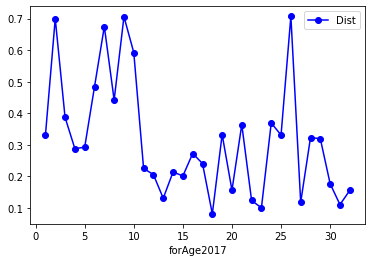

In [53]:
my_Data[my_Data.forAge2017>0].plot(x='forAge2017', y='Dist', style='bo-')

In [54]:
my_Data[(my_Data.forAge2017 > 20) & (my_Data.forAge2017 < 30)].Dist.mean()

0.3062903449167264

In [55]:
# scale the data
df_max_scaled = my_Data.drop(columns=['Dist']).copy()

In [56]:
df_max_scaled.head()

,forAge2017,mean_2017,median_2017,std_2017,MAD_2017,dRange_2017,qDiff_2017,iqRange_2017
0,1.0,-13.874302,-13.841357,1.279677,0.859854,5.333469,3.127712,1.690049
1,2.0,-14.221361,-14.173239,1.327644,0.898981,5.472828,3.259510,1.766026
2,3.0,-13.872849,-13.828423,1.294482,0.869167,5.365298,3.169298,1.712827
3,4.0,-13.822633,-13.783905,1.269209,0.844125,5.282313,3.110118,1.654784
4,5.0,-13.788034,-13.742193,1.266640,0.840152,5.252888,3.110314,1.649716


In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
MinMaxScaler().fit_transform(np.array(my_Data['median_2017']).reshape(-1,1))

array([[0.41464267],
       [0.        ],
       [0.43080286],
       [0.48642235],
       [0.53853551],
       [0.66099456],
       [0.93387002],
       [0.57394264],
       [0.99108738],
       [0.87825995],
       [0.24221605],
       [0.4647317 ],
       [0.48992475],
       [0.27710424],
       [0.42588159],
       [0.62106604],
       [0.57484778],
       [0.4145234 ],
       [0.67647262],
       [0.45118158],
       [0.06014407],
       [0.35498059],
       [0.44083093],
       [0.06943143],
       [0.10017888],
       [1.        ],
       [0.28497715],
       [0.10013034],
       [0.10573602],
       [0.23337312],
       [0.31973376],
       [0.5211896 ],
       [0.38266075]])

In [59]:
my_Data.drop(columns=['forAge2017']).apply(lambda col: MinMaxScaler().fit_transform(np.array(col).reshape(-1,1)), axis=0)

ValueError: If using all scalar values, you must pass an index